In [1]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc.reso='hi'
warnings.filterwarnings('ignore')

In [2]:
REGIONS   = {
    'Eastern Arabian Sea':{'latmin':9.,'latmax':19.5,'lonmin':64.,'lonmax':72.}, 
    'Central India':{'latmin':18.,'latmax':24.,'lonmin':76.,'lonmax':83.},
    'Central Bay of Bengal':{'latmin':9.,'latmax':14.5,'lonmin':86.5,'lonmax':90.},
    'Equatorial Indian Ocean':{'latmin':5.,'latmax':10.,'lonmin':62.,'lonmax':67.5},
    'Konkan Coast':{'latmin':15.,'latmax':19.5,'lonmin':69.,'lonmax':72.5}} 
BINPARAMS = {
    'bl':{'min':-0.6,'max':0.1,'width':0.0025},
    'cape':{'min':-70.,'max':20.,'width':1.},
    'subsat':{'min':-20.,'max':70.,'width':1.}}
FILEDIR = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/data/processed'
SAVEDIR = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/figs'
SAMPLETHRESH = 50

In [3]:
def open_dataset(filename,filedir=FILEDIR):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_dataset(filepath)
    return ds

stats = open_dataset('binned_stats.nc')
data = open_dataset('pr_bl_terms.nc')

In [65]:
def get_region(data,key,regions=REGIONS):
    region = regions[key]
    return data.sel(lat=slice(region['latmin'],region['latmax']),lon=slice(region['lonmin'],region['lonmax']))

def get_month(data,month):
    return data.sel(time=data.time.dt.month==month)

def get_pdf(stats,samplethresh=SAMPLETHRESH):
    Q0 = stats.Q0.values
    QE = stats.QE.values
    QE[QE<samplethresh] = np.nan
    pdf = QE/np.nansum(QE)
    return xr.DataArray(pdf,coords={'bl': stats.bl.values})

def get_bin_mean_pr(stats,samplethresh=SAMPLETHRESH):
    Q0 = stats.Q0.values
    Q1 = stats.Q1.values
    Q0[Q0==0.0] = np.nan
    Q = Q1/Q0
    Q[Q0<samplethresh] = np.nan
    return xr.DataArray(Q,coords={'bl':stats.bl.values})

# def get_bin_mean_pr(stats,bintype,samplethresh=SAMPLETHRESH):
#     if bintype=='1D':
#         Q0 = stats.Q0.values
#         Q1 = stats.Q1.values
#         Q0[Q0==0.0] = np.nan
#         Q = Q1/Q0
#         Q[Q0<samplethresh] = np.nan
#         return Q
#     if bintype=='2D':
#         P0 = stats.P0.values
#         P1 = stats.P1.values
#         P0[P0==0.0] = np.nan
#         P = P1/P0
#         P[P0<samplethresh] = np.nan
#         return P
    
# def interp_from_fit(xfit,yfit,x):
#     xfit = np.array(xfit)
#     yfit = np.array(yfit)
#     binedges = np.concatenate(([xfit[0]-(xfit[1]-xfit[0])/2],(xfit[1:]+xfit[:-1])/2,[xfit[-1]+(xfit[-1]-xfit[-2])/2]))
#     def step_function(x):
#         idxs = np.digitize(x,binedges)-1
#         idxs = np.clip(idxs,0,len(yfit)-1)
#         return yfit[idxs]
#     if isinstance(x,xr.DataArray):
#         result = xr.apply_ufunc(step_function,x,input_core_dims=[[]],output_core_dims=[[]],vectorize=True)
#         return result
#     else:
#         return step_function(x)

# def calc_monthly_mean(ds):
#     return ds.groupby('time.month').mean('time').squeeze()

# def calc_regional_mean(ds):
#     return (ds*np.cos(np.deg2rad(ds.lat))).mean(dim=['lat','lon'])

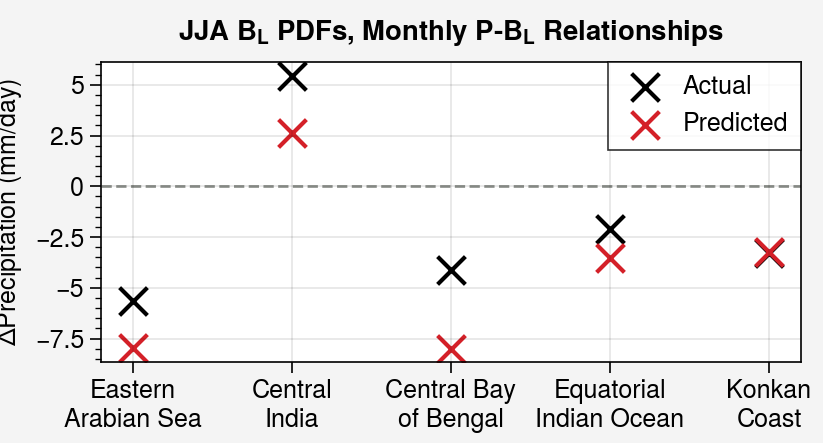

In [71]:
predprdiffs = []
realprdiffs = []
for i,region in enumerate(REGIONS):
    regionstats = stats.sel(region=region)
    regiondata  = get_region(data,region)
    blpdf    = get_pdf(regionstats.sum(dim='month'))
    predprlist = []
    realprlist = []
    months     = [6,7] if i<3 else [7,8]
    for month in months:
        monthstats = regionstats.sel(month=month)
        monthdata  = get_month(regiondata,month)
        binnedpr  = get_bin_mean_pr(monthstats)
        predpr   = np.nansum(blpdf*binnedpr)
        realpr   = monthdata.pr.mean(dim=['lat','lon','time']).values
        predprlist.append(predpr)
        realprlist.append(realpr)
    predprdiffs.append(predprlist[1]-predprlist[0]) 
    realprdiffs.append(realprlist[1]-realprlist[0])

regions = ['Eastern\nArabian Sea','Central\nIndia','Central Bay\nof Bengal','Equatorial\nIndian Ocean','Konkan\nCoast']
realpr = np.asarray(realprdiffs)
predpr = np.asarray(predprdiffs)

fig,ax = pplt.subplots(refheight=1.5,refwidth=3.5)
ax.format(suptitle='JJA $B_L$ PDFs, Monthly P-$B_L$ Relationships',ylabel='$\Delta$Precipitation (mm/day)')
ax.axhline(y=0,color='grey',linestyle='--',linewidth=1,zorder=0)
ax.scatter(regions,realpr,color='k',marker='x',s=100,label='Actual')
ax.scatter(regions,predpr,color='#D42028',marker='x',s=100,label='Predicted')
ax.legend(loc='ur',ncols=1)
pplt.show()

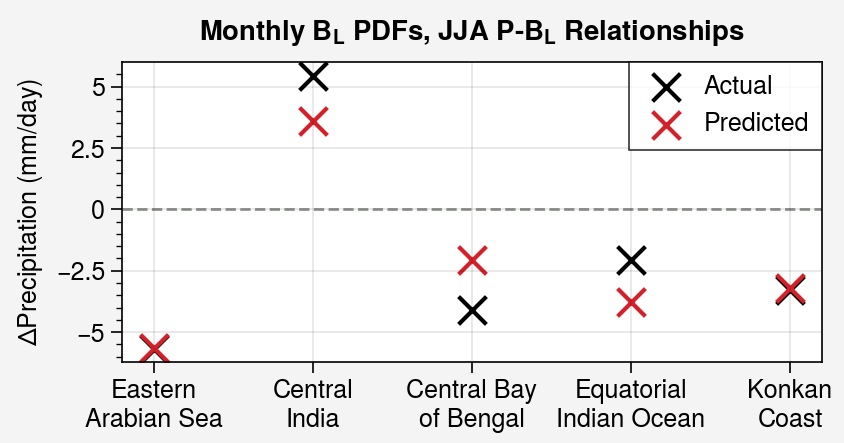

array([ -0.22080554, -33.45380566, -49.52905225,  80.56350591,
        -2.06020015])

In [77]:
predprdiffs = []
realprdiffs = []
for i,region in enumerate(REGIONS):
    regionstats = stats.sel(region=region)
    regiondata  = get_region(data,region)
    binnedpr    = get_bin_mean_pr(regionstats.sum(dim='month'))
    predprlist = []
    realprlist = []
    months     = [6,7] if i<3 else [7,8]
    for month in months:
        monthstats = regionstats.sel(month=month)
        monthdata  = get_month(regiondata,month)
        blpdf    = get_pdf(monthstats)
        predpr   = np.nansum(blpdf*binnedpr)
        realpr   = monthdata.pr.mean(dim=['lat','lon','time']).values
        predprlist.append(predpr)
        realprlist.append(realpr)
    predprdiffs.append(predprlist[1]-predprlist[0])
    realprdiffs.append(realprlist[1]-realprlist[0]) 
    
regions = ['Eastern\nArabian Sea','Central\nIndia','Central Bay\nof Bengal','Equatorial\nIndian Ocean','Konkan\nCoast']
realpr = np.asarray(realprdiffs)
predpr = np.asarray(predprdiffs)

fig,ax = pplt.subplots(refheight=1.5,refwidth=3.5)
ax.format(suptitle='Monthly $B_L$ PDFs, JJA P-$B_L$ Relationships',ylabel='$\Delta$Precipitation (mm/day)')
ax.axhline(y=0,color='grey',linestyle='--',linewidth=1,zorder=0)
ax.scatter(regions,realpr,color='k',marker='x',s=100,label='Actual')
ax.scatter(regions,predpr,color='#D42028',marker='x',s=100,label='Predicted')
ax.legend(loc='ur',ncols=1)
pplt.show()

err = ((predpr-realpr)/realpr)*100
err

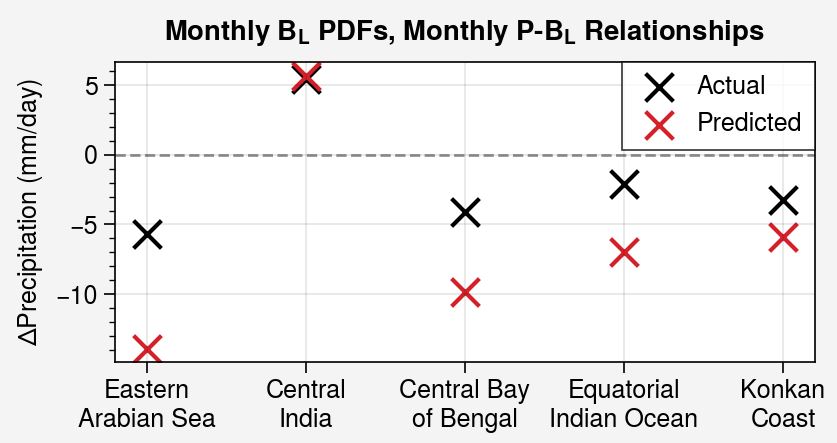

In [73]:
predprdiffs = []
realprdiffs = []
for i,region in enumerate(REGIONS):
    regionstats = stats.sel(region=region)
    regiondata  = get_region(data,region)
    predprlist = []
    realprlist = []
    months     = [6,7] if i<3 else [7,8]
    for month in months:
        monthstats = regionstats.sel(month=month)
        monthdata  = get_month(regiondata,month)
        blpdf    = get_pdf(monthstats)
        binnedpr = get_bin_mean_pr(monthstats)
        predpr   = np.nansum(blpdf*binnedpr)
        realpr   = monthdata.pr.mean(dim=['lat','lon','time']).values
        predprlist.append(predpr)
        realprlist.append(realpr)
    predprdiffs.append(predprlist[1]-predprlist[0]) 
    realprdiffs.append(realprlist[1]-realprlist[0])

regions = ['Eastern\nArabian Sea','Central\nIndia','Central Bay\nof Bengal','Equatorial\nIndian Ocean','Konkan\nCoast']
realpr = np.asarray(realprdiffs)
predpr = np.asarray(predprdiffs)

fig,ax = pplt.subplots(refheight=1.5,refwidth=3.5)
ax.format(suptitle='Monthly $B_L$ PDFs, Monthly P-$B_L$ Relationships',ylabel='$\Delta$Precipitation (mm/day)')
ax.axhline(y=0,color='grey',linestyle='--',linewidth=1,zorder=0)
ax.scatter(regions,realpr,color='k',marker='x',s=100,label='Actual')
ax.scatter(regions,predpr,color='#D42028',marker='x',s=100,label='Predicted')
ax.legend(loc='ur',ncols=1)
pplt.show()

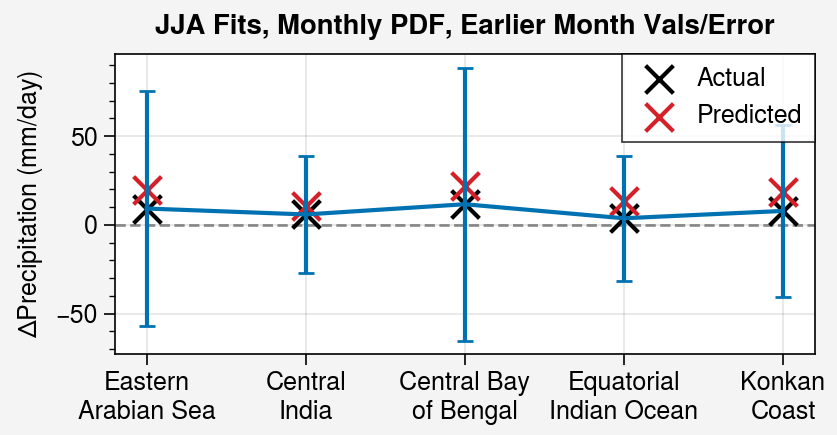

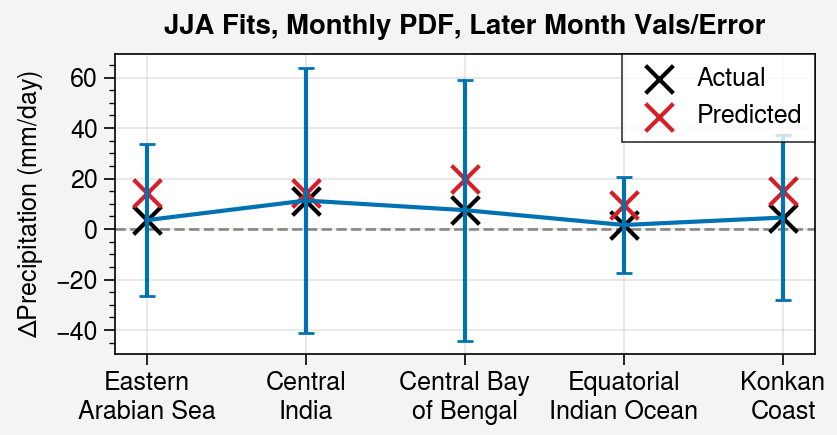

In [31]:
predprdiffs = []
realprdiffs = []
stdprdiffs = []
for i,region in enumerate(REGIONS):
    regionstats = stats.sel(region=region)
    regiondata  = get_region(data,region)
    binnedpr    = get_bin_mean_pr(regionstats.sum(dim='month'))
    predprlist = []
    realprlist = []
    stdprlist = []
    months     = [6,7] if i<3 else [7,8]
    for month in months:
        monthstats = regionstats.sel(month=month)
        monthdata  = get_month(regiondata,month)
        blpdf    = get_pdf(monthstats)
        predpr   = np.nansum(blpdf*binnedpr)
        realpr   = monthdata.pr.mean(dim=['lat','lon','time']).values
        stdpr    = monthdata.pr.std(dim=['lat','lon','time']).values
        predprlist.append(predpr)
        realprlist.append(realpr)
        stdprlist.append(stdpr)
    predprdiffs.append(predprlist[0]) # -predprlist[0]
    realprdiffs.append(realprlist[0]) # -realprlist[0]
    stdprdiffs.append(stdprlist[0]) # -stdprlist[0]
    
regions = ['Eastern\nArabian Sea','Central\nIndia','Central Bay\nof Bengal','Equatorial\nIndian Ocean','Konkan\nCoast']
realpr = np.asarray(realprdiffs)
predpr = np.asarray(predprdiffs)
stdpr = np.asarray(stdprdiffs)

fig,ax = pplt.subplots(refheight=1.5,refwidth=3.5)
ax.format(suptitle='JJA Fits, Monthly PDF, Earlier Month Vals/Error',ylabel='$\Delta$Precipitation (mm/day)')
ax.axhline(y=0,color='grey',linestyle='--',linewidth=1,zorder=0)
ax.scatter(regions,realpr,color='k',marker='x',s=100,label='Actual')
ax.scatter(regions,predpr,color='#D42028',marker='x',s=100,label='Predicted')
ax.errorbar(regions,realpr,yerr=(realpr+stdpr))
ax.legend(loc='ur',ncols=1)
pplt.show()

# STD of the later month -> inside that domain, for that month, the P has way biger variation compared to the prediction diff

predprdiffs = []
realprdiffs = []
stdprdiffs = []
for i,region in enumerate(REGIONS):
    regionstats = stats.sel(region=region)
    regiondata  = get_region(data,region)
    binnedpr    = get_bin_mean_pr(regionstats.sum(dim='month'))
    predprlist = []
    realprlist = []
    stdprlist = []
    months     = [6,7] if i<3 else [7,8]
    for month in months:
        monthstats = regionstats.sel(month=month)
        monthdata  = get_month(regiondata,month)
        blpdf    = get_pdf(monthstats)
        predpr   = np.nansum(blpdf*binnedpr)
        realpr   = monthdata.pr.mean(dim=['lat','lon','time']).values
        stdpr    = monthdata.pr.std(dim=['lat','lon','time']).values
        predprlist.append(predpr)
        realprlist.append(realpr)
        stdprlist.append(stdpr)
    predprdiffs.append(predprlist[1]) # -predprlist[0]
    realprdiffs.append(realprlist[1]) # -realprlist[0]
    stdprdiffs.append(stdprlist[1]) # -stdprlist[0]
    
regions = ['Eastern\nArabian Sea','Central\nIndia','Central Bay\nof Bengal','Equatorial\nIndian Ocean','Konkan\nCoast']
realpr = np.asarray(realprdiffs)
predpr = np.asarray(predprdiffs)
stdpr = np.asarray(stdprdiffs)

fig,ax = pplt.subplots(refheight=1.5,refwidth=3.5)
ax.format(suptitle='JJA Fits, Monthly PDF, Later Month Vals/Error',ylabel='$\Delta$Precipitation (mm/day)')
ax.axhline(y=0,color='grey',linestyle='--',linewidth=1,zorder=0)
ax.scatter(regions,realpr,color='k',marker='x',s=100,label='Actual')
ax.scatter(regions,predpr,color='#D42028',marker='x',s=100,label='Predicted')
ax.errorbar(regions,realpr,yerr=(realpr+stdpr))
ax.legend(loc='ur',ncols=1)
pplt.show()


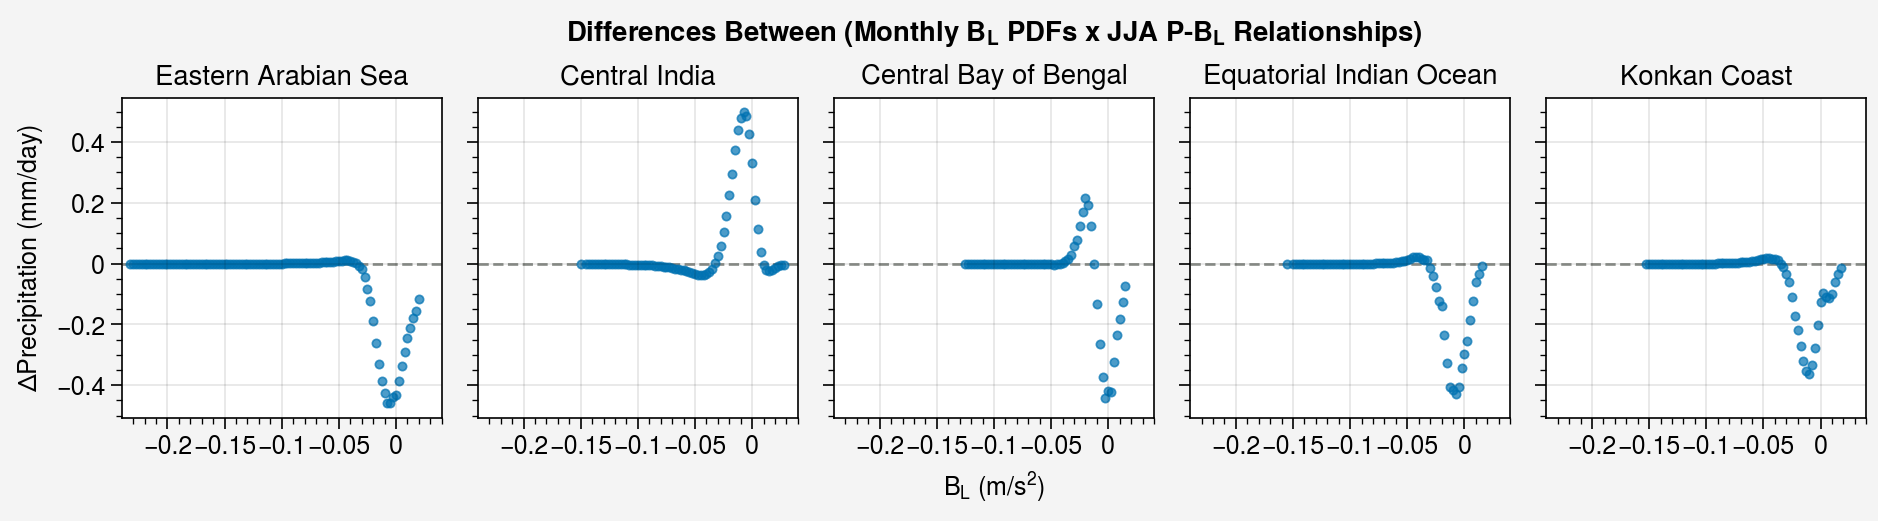

In [74]:
weighteddiffs = []
for i,region in enumerate(REGIONS):
    regionstats  = stats.sel(region=region)
    regiondata   = get_region(data,region)
    binnedpr     = get_bin_mean_pr(regionstats.sum(dim='month'))
    weightedlist = []
    months       = [6,7] if i<3 else [7,8]
    for month in months:
        monthstats = regionstats.sel(month=month)
        monthdata  = get_month(regiondata,month)
        blpdf      = get_pdf(monthstats)
        weighted = blpdf*binnedpr
        weightedlist.append(weighted)
    weighteddiffs.append(weightedlist[1]-weightedlist[0]) 

fig,axs = pplt.subplots(ncols=5,nrows=1,refwidth=1.6)
axs.format(suptitle='Differences Between (Monthly $B_L$ PDFs x JJA P-$B_L$ Relationships)',xlabel='$B_L$ (m/s$^2$)',xlim=(-0.24,0.04),xticks=0.05,
           ylabel='$\Delta$Precipitation (mm/day)')
for i,region in enumerate(REGIONS):
    axs[i].format(title=region)
    axs[i].axhline(y=0,color='grey',linestyle='--',linewidth=1,zorder=0)
    axs[i].scatter(weighteddiffs[i],marker='.',alpha=0.7)
pplt.show()